In [1]:
import pandas as pd
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
sys.path.append('../../')
from scipy.signal import find_peaks
import numpy as np

from scoring.event_detection_matrix import competition_score
from tqdm import tqdm

## Daten laden

In [2]:
predictions = pd.read_parquet('./test/predicted_series_cp_4h_v2.parquet')
validation_events = pd.read_csv('../../data/processed/validation_events_split.csv')

In [3]:
predictions['series_id'] = predictions['num_series_id']

In [4]:
predictions

step  num_series_id  onset_critical_event_point  \
0             0              7                         0.0   
1            12              7                         0.0   
2            24              7                         0.0   
3            36              7                         0.0   
4            48              7                         0.0   
...         ...            ...                         ...   
1434339  620581            276                         0.0   
1434340  620593            276                         0.0   
1434341  620605            276                         0.0   
1434342  620617            276                         0.0   
1434343  620629            276                         0.0   

         wakeup_critical_event_point  prediction_confidence_onset  \
0                                0.0                     0.000013   
1                                0.0                     0.000013   
2                                0.0                     0.000013   
3                                0.0                     0.000013   
4                                0.0                     0.000014   
...                              ...                          ...   
1434339                          0.0                     0.001130   
1434340                          0.0                     0.001146   
1434341                          0.0                     0.001131   
1434342                          0.0                     0.001101   
1434343                          0.0                     0.001058   

         prediction_confidence_wakeup  series_id  
0                            0.000004          7  
1                            0.000004          7  
2                            0.000004          7  
3                            0.000004          7  
4                            0.000004          7  
...                               ...        ...  
1434339                      0.000331        276  
1434340                      0.000309        276  
1434341                      0.000292        276  
1434342                      0.000279        276  
1434343                      0.000271        276  

[1434344 rows x 7 columns]

In [5]:
validation_events

series_id  night   event      step                 timestamp  \
0     062dbd4c95e6      1   onset    7872.0  2018-08-22T23:11:00-0400   
1     062dbd4c95e6      1  wakeup   14484.0  2018-08-23T08:22:00-0400   
2     062dbd4c95e6      2   onset       NaN                       NaN   
3     062dbd4c95e6      2  wakeup       NaN                       NaN   
4     062dbd4c95e6      3   onset       NaN                       NaN   
...            ...    ...     ...       ...                       ...   
2957  fcca183903b7     34  wakeup  584052.0  2019-04-29T08:11:00-0400   
2958  fcca183903b7     35   onset  595344.0  2019-04-29T23:52:00-0400   
2959  fcca183903b7     35  wakeup  602136.0  2019-04-30T09:18:00-0400   
2960  fcca183903b7     36   onset       NaN                       NaN   
2961  fcca183903b7     36  wakeup       NaN                       NaN   

      num_series_id  
0                 7  
1                 7  
2                 7  
3                 7  
4                 7  
...             ...  
2957            276  
2958            276  
2959            276  
2960            276  
2961            276  

[2962 rows x 6 columns]

In [6]:
validation_events[validation_events.num_series_id == 16]

series_id  night   event      step                 timestamp  \
130  0ef7d94fde99      1   onset    3684.0  2018-01-26T22:37:00-0500   
131  0ef7d94fde99      1  wakeup    9888.0  2018-01-27T07:14:00-0500   
132  0ef7d94fde99      2   onset   20340.0  2018-01-27T21:45:00-0500   
133  0ef7d94fde99      2  wakeup   27444.0  2018-01-28T07:37:00-0500   
134  0ef7d94fde99      3   onset   36168.0  2018-01-28T19:44:00-0500   
135  0ef7d94fde99      3  wakeup   43560.0  2018-01-29T06:00:00-0500   
136  0ef7d94fde99      4   onset   53808.0  2018-01-29T20:14:00-0500   
137  0ef7d94fde99      4  wakeup   60924.0  2018-01-30T06:07:00-0500   
138  0ef7d94fde99      5   onset   71640.0  2018-01-30T21:00:00-0500   
139  0ef7d94fde99      5  wakeup   77796.0  2018-01-31T05:33:00-0500   
140  0ef7d94fde99      6   onset   88776.0  2018-01-31T20:48:00-0500   
141  0ef7d94fde99      6  wakeup   95304.0  2018-02-01T05:52:00-0500   
142  0ef7d94fde99      7   onset  105924.0  2018-02-01T20:37:00-0500   
143  0ef7d94fde99      7  wakeup  112176.0  2018-02-02T05:18:00-0500   
144  0ef7d94fde99      8   onset  125628.0  2018-02-02T23:59:00-0500   
145  0ef7d94fde99      8  wakeup  130584.0  2018-02-03T06:52:00-0500   
146  0ef7d94fde99      9   onset  142056.0  2018-02-03T22:48:00-0500   
147  0ef7d94fde99      9  wakeup  147912.0  2018-02-04T06:56:00-0500   
148  0ef7d94fde99     10   onset  158040.0  2018-02-04T21:00:00-0500   
149  0ef7d94fde99     10  wakeup  164748.0  2018-02-05T06:19:00-0500   
150  0ef7d94fde99     11   onset  174996.0  2018-02-05T20:33:00-0500   
151  0ef7d94fde99     11  wakeup  181344.0  2018-02-06T05:22:00-0500   
152  0ef7d94fde99     12   onset  192072.0  2018-02-06T20:16:00-0500   
153  0ef7d94fde99     12  wakeup  198864.0  2018-02-07T05:42:00-0500   
154  0ef7d94fde99     13   onset  209952.0  2018-02-07T21:06:00-0500   
155  0ef7d94fde99     13  wakeup  216264.0  2018-02-08T05:52:00-0500   
156  0ef7d94fde99     14   onset  231048.0  2018-02-09T02:24:00-0500   
157  0ef7d94fde99     14  wakeup  233544.0  2018-02-09T05:52:00-0500   
158  0ef7d94fde99     15   onset  246372.0  2018-02-09T23:41:00-0500   
159  0ef7d94fde99     15  wakeup  251412.0  2018-02-10T06:41:00-0500   
160  0ef7d94fde99     16   onset  262392.0  2018-02-10T21:56:00-0500   
161  0ef7d94fde99     16  wakeup  268416.0  2018-02-11T06:18:00-0500   
162  0ef7d94fde99     17   onset  278460.0  2018-02-11T20:15:00-0500   
163  0ef7d94fde99     17  wakeup  285480.0  2018-02-12T06:00:00-0500   
164  0ef7d94fde99     18   onset  296100.0  2018-02-12T20:45:00-0500   
165  0ef7d94fde99     18  wakeup  302784.0  2018-02-13T06:02:00-0500   
166  0ef7d94fde99     19   onset  316572.0  2018-02-14T01:11:00-0500   
167  0ef7d94fde99     19  wakeup  319764.0  2018-02-14T05:37:00-0500   
168  0ef7d94fde99     20   onset  331824.0  2018-02-14T22:22:00-0500   
169  0ef7d94fde99     20  wakeup  336912.0  2018-02-15T05:26:00-0500   
170  0ef7d94fde99     21   onset  350856.0  2018-02-16T00:48:00-0500   
171  0ef7d94fde99     21  wakeup  351624.0  2018-02-16T01:52:00-0500   
172  0ef7d94fde99     22   onset       NaN                       NaN   
173  0ef7d94fde99     22  wakeup       NaN                       NaN   

     num_series_id  
130             16  
131             16  
132             16  
133             16  
134             16  
135             16  
136             16  
137             16  
138             16  
139             16  
140             16  
141             16  
142             16  
143             16  
144             16  
145             16  
146             16  
147             16  
148             16  
149             16  
150             16  
151             16  
152             16  
153             16  
154             16  
155             16  
156             16  
157             16  
158             16  
159             16  
160             16  
161             16  
162             16  
163             16  
164             16  
165        

## Event Extraction

In [7]:
smoothing_length = 30 * 12 # 30min
day_step_len = 12 * 60 * 24 # 24h

def get_events_day(series_id, X, prominence):
    start_step = X.iloc[0].name
    peaks_onset = find_peaks(X.prediction_confidence_onset.values, prominence=prominence)
    peaks_wakeup = find_peaks(X.prediction_confidence_wakeup.values, prominence=prominence)

    events = []
    for i in range(len(peaks_onset[0])):
        events.append({'series_id': series_id, 'step': start_step + peaks_onset[0][i], 'event': 'onset', 'score': peaks_onset[1]['prominences'][i]})

    for i in range(len(peaks_wakeup[0])):
        events.append({'series_id': series_id, 'step': start_step + peaks_wakeup[0][i], 'event': 'wakeup', 'score': peaks_wakeup[1]['prominences'][i]})
    
    return events

def get_events_smoothed(test_series, prominence) :
    series_ids = test_series['num_series_id'].unique()
    events = []

    for idx in tqdm(series_ids):
        X = test_series[test_series.num_series_id == idx]
        X = X.set_index('step')
        X = X.reindex(range(X.index.min(), X.index.max() + 1))
        X = X.ffill()
        seq_len = len(X)

        for j in range(0, seq_len, day_step_len):
            events.extend(get_events_day(idx, X[j:j+day_step_len], prominence))

            
    return pd.DataFrame(events).reset_index().rename(columns={'index': 'row_id'})

In [8]:
validation_events['series_id'] = validation_events['num_series_id']
validation_events = validation_events[validation_events.step.notnull()]

In [9]:
for i in range(1, 9):
    prominence = i / 10
    predicted_validation_events = get_events_smoothed(predictions, prominence)
    score = competition_score(validation_events, predicted_validation_events)
    print(f'Prominence: {prominence}, Score: {score}') 

100%|██████████| 54/54 [00:01<00:00, 30.63it/s]


Prominence: 0.1, Score: 0.5023974104925462


100%|██████████| 54/54 [00:01<00:00, 30.23it/s]


Prominence: 0.2, Score: 0.49448979098038276


100%|██████████| 54/54 [00:01<00:00, 30.53it/s]


Prominence: 0.3, Score: 0.4867677629798064


100%|██████████| 54/54 [00:01<00:00, 30.49it/s]


Prominence: 0.4, Score: 0.4746867839979203


100%|██████████| 54/54 [00:01<00:00, 30.56it/s]


Prominence: 0.5, Score: 0.45506674108722933


100%|██████████| 54/54 [00:01<00:00, 30.45it/s]


Prominence: 0.6, Score: 0.4135855687825979


100%|██████████| 54/54 [00:01<00:00, 30.48it/s]


Prominence: 0.7, Score: 0.3304009096902748


100%|██████████| 54/54 [00:01<00:00, 30.83it/s]


Prominence: 0.8, Score: 0.12901445419401952


In [10]:
predicted_events = get_events_smoothed(predictions, 0.1)

100%|██████████| 54/54 [00:01<00:00, 30.68it/s]


In [11]:
competition_score(validation_events, predicted_events)

0.5023974104925462

## Competition Score pro Serie

In [12]:
validation_events['series_id'] = validation_events['num_series_id']

/tmp/ipykernel_33281/2944615167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_events['series_id'] = validation_events['num_series_id']


In [13]:
series_ids = predicted_events.series_id.unique()
scores = []

for series_id in tqdm(series_ids):
    predicted_events_series = predicted_events[predicted_events.series_id == series_id]
    true_events_series = validation_events[validation_events.series_id == series_id]

    score = competition_score(true_events_series, predicted_events_series)
    
    scores.append({'series_id': str(series_id), 'score': score})

scores = pd.DataFrame(scores)

100%|██████████| 54/54 [00:13<00:00,  4.14it/s]


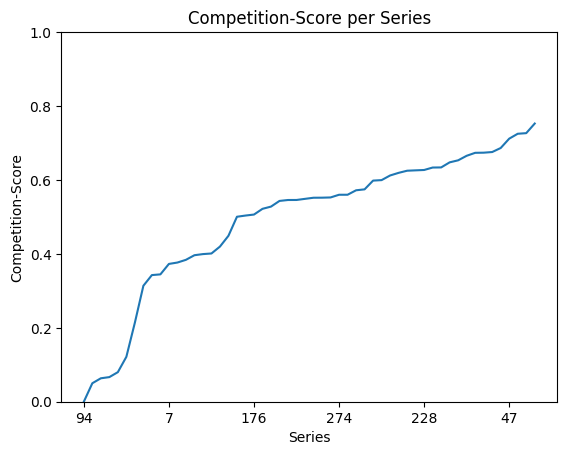

In [14]:
ax = scores.groupby('series_id')['score'].mean().sort_values().plot(
    ylim=(0, 1), title='Competition-Score per Series'
)
ax.set_ylabel("Competition-Score")
ax.set_xlabel("Series")
#ax.set_xticks(ticks=[*range(1, len(series), 2)], labels=series[::2], rotation=90)

fig = ax.get_figure()
fig.savefig("comp-score-per-series.png", bbox_inches="tight")

In [15]:
scores.sort_values(by='score')

series_id     score
17        94  0.000000
48       250  0.050000
50       267  0.063408
12        71  0.066602
39       196  0.080000
5         26  0.121506
35       187  0.213889
21       117  0.313750
6         27  0.342637
31       171  0.344565
0          7  0.372821
38       192  0.376582
15        83  0.383904
26       129  0.396370
1         10  0.399425
4         24  0.401071
16        86  0.419734
37       191  0.448998
42       210  0.500470
13        72  0.503690
32       176  0.506409
20       113  0.521898
41       204  0.527926
27       131  0.543291
19       108  0.545774
8         44  0.545854
28       142  0.548903
46       232  0.551911
30       155  0.552053
11        63  0.552681
52       274  0.559976
23       122  0.560000
36       190  0.572061
2         16  0.574594
29       148  0.598259
22       120  0.599588
44       225  0.612122
47       248  0.619236
43       217  0.625000
18        97  0.626015
45       228  0.626988
3         21  0.633606
7         32  0.633910
24       123  0.647647
40       199  0.653170
51       270  0.665422
25       124  0.673445
10        48  0.673814
53       276  0.675572
14        81  0.686480
9         47  0.711759
33       179  0.725000
34       185  0.726638
49       251  0.752657

## Daten visualisieren

In [16]:
participant_series_id = 232
participant_series = predictions[predictions.series_id == participant_series_id]
participant_series = participant_series[0:100_000]

participant_events = predicted_events[predicted_events.series_id == participant_series_id]
participant_events = participant_events[0:34]

participant_true_events = validation_events[validation_events.series_id == participant_series_id]
participant_true_events = participant_true_events[0:34]

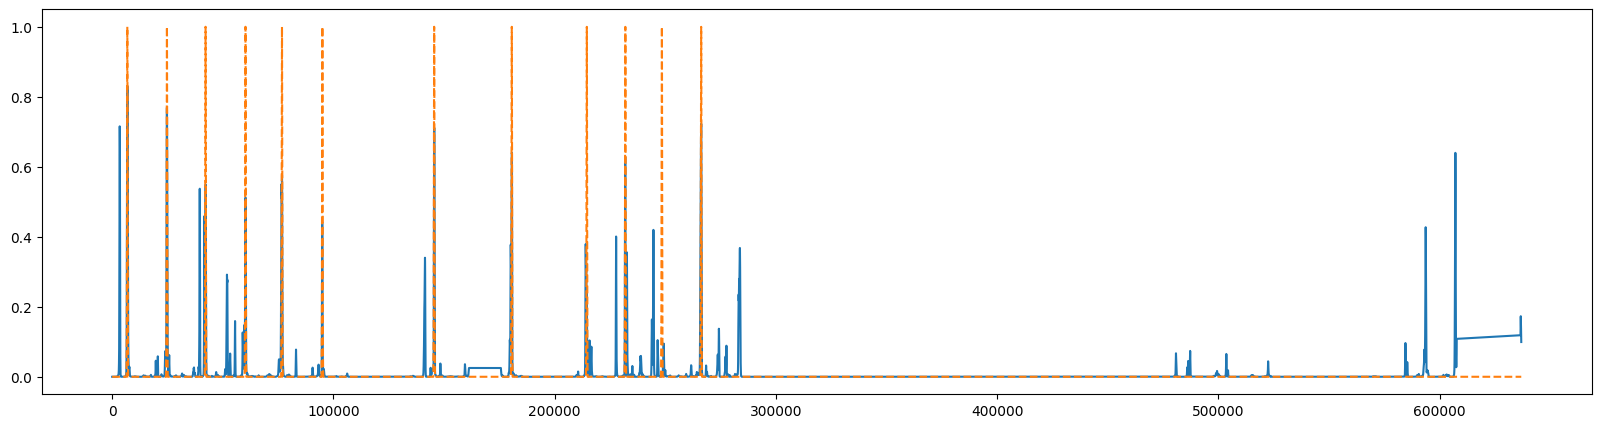

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(participant_series['step'], participant_series['prediction_confidence_onset'])
plt.plot(participant_series['step'], participant_series['onset_critical_event_point'], linestyle='dashed')
plt.show()

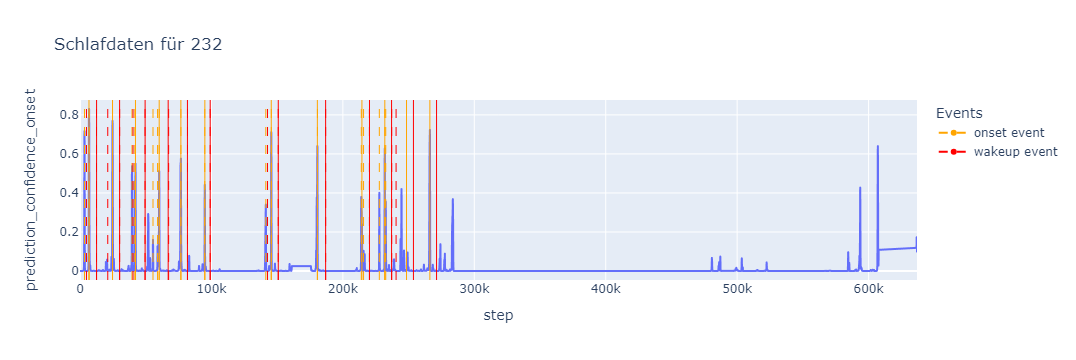

In [18]:
fig = px.line(participant_series, x='step', y='prediction_confidence_onset', title=f'Schlafdaten für {participant_series_id}')
for index, row in participant_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_dash='dash', line_color=color)
    
for index, row in participant_true_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_color=color)

#Custom Legend
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='orange', width=2, dash='dash'),
        name="onset event",
    )
)
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='red', width=2, dash='dash'),
        name="wakeup event",
    )
)
fig.update_layout(legend_title="Events")
    
fig.show()

## Analysis for different thresholds

In [19]:
import sys
sys.path.append('../')

from scoring.event_detection_ap import score

In [20]:
base_tolerances = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]

column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

In [21]:
validation_events = validation_events[validation_events.step.notnull()]
validation_events

series_id  night   event      step                 timestamp  \
0             7      1   onset    7872.0  2018-08-22T23:11:00-0400   
1             7      1  wakeup   14484.0  2018-08-23T08:22:00-0400   
6             7      4   onset   60720.0  2018-08-26T00:35:00-0400   
7             7      4  wakeup   68400.0  2018-08-26T11:15:00-0400   
8             7      5   onset   77304.0  2018-08-26T23:37:00-0400   
...         ...    ...     ...       ...                       ...   
2955        276     33  wakeup  565824.0  2019-04-28T06:52:00-0400   
2956        276     34   onset  577344.0  2019-04-28T22:52:00-0400   
2957        276     34  wakeup  584052.0  2019-04-29T08:11:00-0400   
2958        276     35   onset  595344.0  2019-04-29T23:52:00-0400   
2959        276     35  wakeup  602136.0  2019-04-30T09:18:00-0400   

      num_series_id  
0                 7  
1                 7  
6                 7  
7                 7  
8                 7  
...             ...  
2955            276  
2956            276  
2957            276  
2958            276  
2959            276  

[1730 rows x 6 columns]

In [22]:
competition_score(validation_events, predicted_events)

0.5023974104925462

In [23]:
comp_scores = []
for i in range(0, 10):
    tolerances = {
        'onset': base_tolerances[:i+1],
        'wakeup': base_tolerances[:i+1],
    }
    comp_scores.append(score(validation_events, predicted_events, tolerances, **column_names))
    print(f'Competition-Score for tolerances {base_tolerances[:i+1]}: {comp_scores[-1]}')

Competition-Score for tolerances [12]: 0.021814030296413774
Competition-Score for tolerances [12, 36]: 0.09272837501740613
Competition-Score for tolerances [12, 36, 60]: 0.1703611582663671
Competition-Score for tolerances [12, 36, 60, 90]: 0.24769460188559134
Competition-Score for tolerances [12, 36, 60, 90, 120]: 0.31355072037911874
Competition-Score for tolerances [12, 36, 60, 90, 120, 150]: 0.36658821693242694
Competition-Score for tolerances [12, 36, 60, 90, 120, 150, 180]: 0.4094359026249974
Competition-Score for tolerances [12, 36, 60, 90, 120, 150, 180, 240]: 0.4452985555231722
Competition-Score for tolerances [12, 36, 60, 90, 120, 150, 180, 240, 300]: 0.4760473129037956
Competition-Score for tolerances [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]: 0.5023974104925462


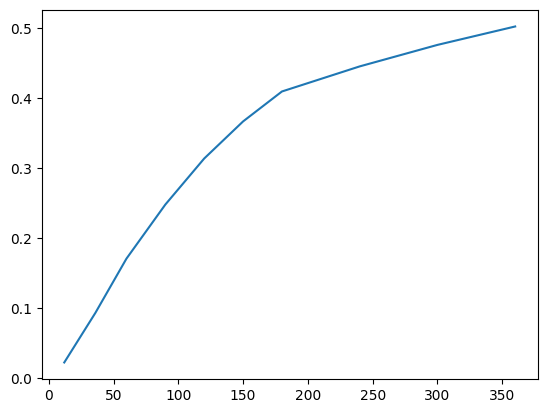

In [24]:
plt.plot(base_tolerances, comp_scores)

In [25]:
single_comp_scores = []
for i in range(0, 10):
    tolerances = {
        'onset': base_tolerances[i:i+1],
        'wakeup': base_tolerances[i:i+1],
    }
    single_comp_scores.append(score(validation_events, predicted_events, tolerances, **column_names))
    print(f'Competition-Score for tolerance {base_tolerances[i:i+1]}: {single_comp_scores[-1]}')

Competition-Score for tolerance [12]: 0.021814030296413774
Competition-Score for tolerance [36]: 0.1636427197383985
Competition-Score for tolerance [60]: 0.3256267247642891
Competition-Score for tolerance [90]: 0.47969493274326397
Competition-Score for tolerance [120]: 0.5769751943532284
Competition-Score for tolerance [150]: 0.6317756996989681
Competition-Score for tolerance [180]: 0.6665220167804198
Competition-Score for tolerance [240]: 0.6963371258103958
Competition-Score for tolerance [300]: 0.7220373719487829
Competition-Score for tolerance [360]: 0.7395482887913016


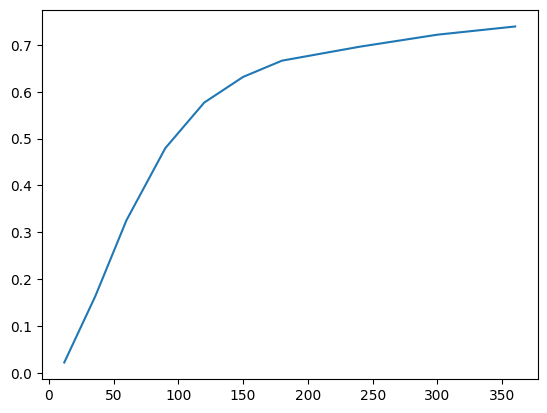

In [26]:
plt.plot(base_tolerances, single_comp_scores)